# <p style="text-align: center;">Multi-Layer Perceptron (MLP) example in Keras <br> for house sales price prediction<br>using BOTH numerical and categorial features
</p>

<p style="text-align: center;">
 by Prof. Dr.-Ing. Jürgen Brauer, http://www.juergenbrauer.org
</p>

## Table of Contents

1. Read in the data and deal with "NaN" values
2. Prepare numerical features
3. Prepare categorial features
4. Combine numerical and categorial feature columns
5. Build and train MLP model
6. Testing the trained MLP
7. Predicting house prices for the Kaggle competition

## 1. Read in the data and deal with "NaN" values

In [23]:
import pandas as pd
train_data = pd.read_csv("kaggle_dataset_house_prices/train.csv")
test_data  = pd.read_csv("kaggle_dataset_house_prices/test.csv")

train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000


## 2. Prepare numerical features

In [24]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True) # do not use scientific "e"-notation

# 1.
# prepare Pandas DataFrames only with numerical columns
train_data_num_only = train_data.select_dtypes(exclude=['object'])
test_data_num_only  = test_data.select_dtypes(exclude=['object'])

# 2.
# Throw away "Id" and SalePrice" column for training data
train_input_matrix = train_data_num_only.values[:,1:37]
train_output_matrix = train_data_num_only.values[:,37]
train_output_matrix = train_output_matrix.reshape(-1,1)

# 3.
# Throw away "Id" column for test input matrix
test_input_matrix  = test_data_num_only.values[:,1:]

# 4.
# create a MinMaxScaler with feature range [0,1]
# and use it to normalize the train_input_matrix
# Then use the SAME normalization to normalize test_data_matrix
scaler_input_features = MinMaxScaler(feature_range=(0, 1))
normalized_train_input_matrix_feats = scaler_input_features.fit_transform(train_input_matrix)
normalized_test_input_matrix_feats = scaler_input_features.transform(test_input_matrix)

# 5.
# Also create a MinMaxScaler for the train_output_matrix,
# which is essentially a column with the final SalePrice
scaler_saleprice = MinMaxScaler(feature_range=(0, 1))
normalized_train_output_matrix = scaler_saleprice.fit_transform(train_output_matrix)

## 3. Prepare categorial features

In [25]:
# 1.
# save the house Ids, since we need them later
# for our Kaggle submission
test_house_ids = test_data.values[:,0] # get the IDs from the original Pandas DataFrame


# 2.
# get Pandas data frames without the numerical features
gt_saleprice = train_data["SalePrice"]
train_data_cats_only = train_data.select_dtypes(exclude=['number'])
test_data_cats_only = test_data.select_dtypes(exclude=['number'])


# 3.
# map each single categorial column
# to multiple (one-hot encoded) columns
print(train_data_cats_only.dtypes)
frames = [train_data_cats_only, test_data_cats_only]
fused_df = pd.concat(frames)
print("Shape of fused_df is", fused_df.shape)

# now do the one-hot encoding
fused_df_hot_encoded = pd.get_dummies(fused_df)
print("Shape of fused_df_hot_encoded is", fused_df_hot_encoded.shape)

# now split the data frame into two data frames again
# with 1460 and 1459 rows
train_data_hot_encoded = fused_df_hot_encoded[0:1460]
test_data_hot_encoded  = fused_df_hot_encoded[1460:]


# 4.
# prepare NumPy matrices for training
# from Pandas DataFrames
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# define how NumPy shall print matrices
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True) # do not use scientific "e"-notation

# convert Pandas DataFrame to NumPy matrices
# since Keras will expect NumPy matrices
train_input_matrix_cat = train_data_hot_encoded.values
train_output_matrix    = gt_saleprice.values
train_output_matrix    = train_output_matrix.reshape(-1,1)
test_input_matrix_cat  = test_data_hot_encoded.values

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

## 4. Combine numerical and categorial feature columns

We have now a training matrix with numerical features and a training matrix with categorial one-hot encoded features:

In [26]:
print("There are", normalized_train_input_matrix_feats.shape[1],
      "many numerical features that will be used.")
print("\tnormalized_train_input_matrix_feats has shape",
      normalized_train_input_matrix_feats.shape)
print("\tnormalized_test_input_matrix_feats has shape",
      normalized_test_input_matrix_feats.shape)

print("There are", train_input_matrix_cat.shape[1],
      "many categorial features that will be used.")
print("\ttrain_input_matrix_cat has shape",
      train_input_matrix_cat.shape)
print("\ttrain_input_matrix_cat has shape",
      train_input_matrix_cat.shape)

# concatenate the two input matrices horizontally
all_input_feats_train = np.hstack((normalized_train_input_matrix_feats,
                                   train_input_matrix_cat))
print("all_input_feats_train has shape", all_input_feats_train.shape)
all_input_feats_test = np.hstack((normalized_test_input_matrix_feats ,
                                   test_input_matrix_cat))
print("all_input_feats_test has shape", all_input_feats_test.shape)



There are 36 many numerical features that will be used.
	normalized_train_input_matrix_feats has shape (1460, 36)
	normalized_test_input_matrix_feats has shape (1459, 36)
There are 275 many categorial features that will be used.
	train_input_matrix_cat has shape (1460, 275)
	train_input_matrix_cat has shape (1460, 275)
all_input_feats_train has shape (1460, 311)
all_input_feats_test has shape (1459, 311)


## 5. Build and train MLP model

In [48]:
from keras.models import Sequential
from keras import layers
from keras.layers.core import Dense, Dropout
import pandas as pd
import numpy as np

model = Sequential()
model.add(Dense(50, activation="linear"))
model.add(Dense(10, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss='mean_squared_error', optimizer='sgd')

X = all_input_feats_train
Y = normalized_train_output_matrix
print("Input X has shape", X.shape)
print("Desired output Y has shape", Y.shape)
print("Y:\n", Y)
model.fit(X,Y, validation_split=0.10, epochs=500)
#model.fit(X,Y, epochs=1000)

Input X has shape (1460, 311)
Desired output Y has shape (1460, 1)
Y:
 [[0.2411]
 [0.2036]
 [0.2619]
 ...
 [0.3216]
 [0.1489]
 [0.1564]]
Train on 1314 samples, validate on 146 samples
Epoch 1/500
1314/1314 [==============================] - 0s 372us/step - loss: 0.1469 - val_loss: 0.0766
Epoch 2/500
1314/1314 [==============================] - 0s 52us/step - loss: 0.0509 - val_loss: 0.0470
Epoch 3/500
1314/1314 [==============================] - 0s 53us/step - loss: 0.0343 - val_loss: 0.0322
Epoch 4/500
1314/1314 [==============================] - 0s 56us/step - loss: 0.0264 - val_loss: 0.0272
Epoch 5/500
1314/1314 [==============================] - 0s 67us/step - loss: 0.0217 - val_loss: 0.0203
Epoch 6/500
1314/1314 [==============================] - 0s 52us/step - loss: 0.0178 - val_loss: 0.0426
Epoch 7/500
1314/1314 [==============================] - 0s 65us/step - loss: 0.0160 - val_loss: 0.0158
Epoch 8/500
1314/1314 [==============================] - 0s 74us/step - loss: 0.0139 - 

1314/1314 [==============================] - 0s 42us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 78/500
1314/1314 [==============================] - 0s 42us/step - loss: 0.0027 - val_loss: 0.0035
Epoch 79/500
1314/1314 [==============================] - 0s 62us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 80/500
1314/1314 [==============================] - 0s 41us/step - loss: 0.0026 - val_loss: 0.0033
Epoch 81/500
1314/1314 [==============================] - 0s 39us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 82/500
1314/1314 [==============================] - 0s 42us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 83/500
1314/1314 [==============================] - 0s 55us/step - loss: 0.0026 - val_loss: 0.0035
Epoch 84/500
1314/1314 [==============================] - 0s 67us/step - loss: 0.0026 - val_loss: 0.0032
Epoch 85/500
1314/1314 [==============================] - 0s 55us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 86/500
1314/1314 [==============================] - 0s 55us/st

1314/1314 [==============================] - 0s 78us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 155/500
1314/1314 [==============================] - 0s 54us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 156/500
1314/1314 [==============================] - 0s 76us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 157/500
1314/1314 [==============================] - 0s 70us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 158/500
1314/1314 [==============================] - 0s 59us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 159/500
1314/1314 [==============================] - 0s 59us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 160/500
1314/1314 [==============================] - 0s 60us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 161/500
1314/1314 [==============================] - 0s 62us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 162/500
1314/1314 [==============================] - 0s 54us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 163/500
1314/1314 [==============================] - 0

1314/1314 [==============================] - 0s 67us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 232/500
1314/1314 [==============================] - 0s 55us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 233/500
1314/1314 [==============================] - 0s 72us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 234/500
1314/1314 [==============================] - 0s 64us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 235/500
1314/1314 [==============================] - 0s 43us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 236/500
1314/1314 [==============================] - 0s 41us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 237/500
1314/1314 [==============================] - 0s 48us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 238/500
1314/1314 [==============================] - 0s 41us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 239/500
1314/1314 [==============================] - 0s 42us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 240/500
1314/1314 [==============================] - 0

1314/1314 [==============================] - 0s 53us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 309/500
1314/1314 [==============================] - 0s 50us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 310/500
1314/1314 [==============================] - 0s 46us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 311/500
1314/1314 [==============================] - 0s 42us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 312/500
1314/1314 [==============================] - 0s 41us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 313/500
1314/1314 [==============================] - 0s 46us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 314/500
1314/1314 [==============================] - 0s 45us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 315/500
1314/1314 [==============================] - 0s 45us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 316/500
1314/1314 [==============================] - 0s 46us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 317/500
1314/1314 [==============================] - 0

1314/1314 [==============================] - 0s 74us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 386/500
1314/1314 [==============================] - 0s 59us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 387/500
1314/1314 [==============================] - 0s 55us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 388/500
1314/1314 [==============================] - 0s 52us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 389/500
1314/1314 [==============================] - 0s 48us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 390/500
1314/1314 [==============================] - 0s 48us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 391/500
1314/1314 [==============================] - 0s 50us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 392/500
1314/1314 [==============================] - 0s 68us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 393/500
1314/1314 [==============================] - 0s 51us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 394/500
1314/1314 [==============================] - 0

1314/1314 [==============================] - 0s 54us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 463/500
1314/1314 [==============================] - 0s 62us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 464/500
1314/1314 [==============================] - 0s 45us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 465/500
1314/1314 [==============================] - 0s 55us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 466/500
1314/1314 [==============================] - 0s 43us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 467/500
1314/1314 [==============================] - 0s 44us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 468/500
1314/1314 [==============================] - 0s 47us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 469/500
1314/1314 [==============================] - 0s 45us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 470/500
1314/1314 [==============================] - 0s 42us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 471/500
1314/1314 [==============================] - 0

## 6. Testing the trained MLP

preds_train_houses:
 [[0.2482]
 [0.2574]
 [0.2504]
 ...
 [0.3069]
 [0.1626]
 [0.1552]]
preds_train_houses_dollar:
 [[213601.83]
 [220262.34]
 [215208.86]
 ...
 [255902.66]
 [151988.06]
 [146653.62]]
Shape of preds_train_houses is (1460, 1)
Shape of preds_train_houses_dollar is (1460, 1)


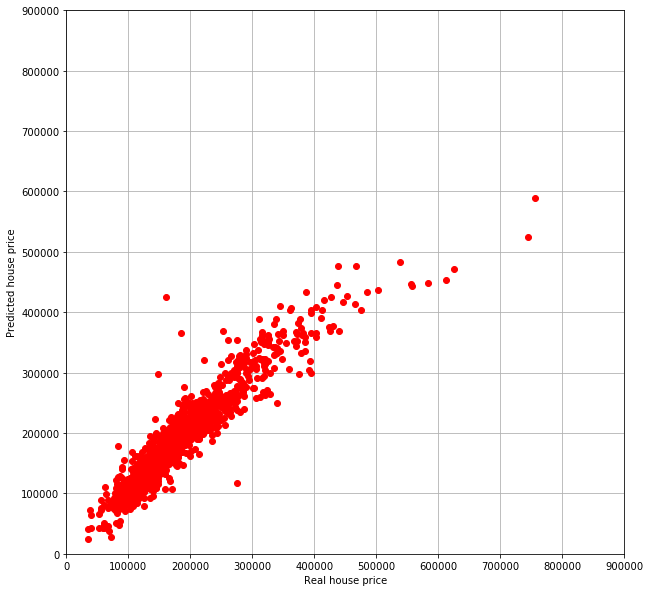

In [49]:
import matplotlib.pyplot as plt

preds_train_houses = model.predict(all_input_feats_train)
print("preds_train_houses:\n", preds_train_houses)
preds_train_houses_dollar = scaler_saleprice.inverse_transform(preds_train_houses)
print("preds_train_houses_dollar:\n", preds_train_houses_dollar)
print("Shape of preds_train_houses is", preds_train_houses.shape)
print("Shape of preds_train_houses_dollar is", preds_train_houses_dollar.shape)
plt.figure( figsize=(10,10) )
plt.plot(train_output_matrix, preds_train_houses_dollar, 'ro')
plt.xlabel('Real house price', fontsize = 10)
plt.ylabel('Predicted house price', fontsize = 10)
plt.grid(True)
plt.xlim(0,900000)
plt.ylim(0,900000)
plt.show()

## 7. Predicting house prices for the Kaggle competition

In [50]:
# PREDICT house prices for all the test houses!
preds_test_houses = model.predict(all_input_feats_test)
preds_test_houses_dollar = scaler_saleprice.inverse_transform(preds_test_houses)


# generate a Pandas dataframe
# from the NumPy prediction_matrix
preds_test_houses_dollar = preds_test_houses_dollar.reshape(-1)
print("test_house_ids has shape", test_house_ids.shape)
print("preds_test_houses_dollar has shape", preds_test_houses_dollar.shape)
predition_dataframe = pd.DataFrame({'Id'       :test_house_ids,
                                    'SalePrice':preds_test_houses_dollar}
                                  )

# convert column "Id" to int64 dtype
predition_dataframe = predition_dataframe.astype({"Id": int})
print(predition_dataframe)

# now save the Pandas dataframe to a .csv file
PREDICTION_FILENAME = "my_predicted_house_prices.csv"
predition_dataframe.to_csv(PREDICTION_FILENAME, sep=',', index=False)

test_house_ids has shape (1459,)
preds_test_houses_dollar has shape (1459,)
        Id      SalePrice
0     1461  119813.187500
1     1462  189633.578125
2     1463  183217.812500
3     1464  200919.046875
4     1465  227115.421875
5     1466  169045.812500
6     1467  189203.781250
7     1468  165023.859375
8     1469  204031.953125
9     1470  131496.281250
10    1471  152464.640625
11    1472  110245.796875
12    1473   96526.546875
13    1474  136878.546875
14    1475   89723.304688
15    1476  375433.625000
16    1477  262517.031250
17    1478  341657.343750
18    1479  328906.531250
19    1480  469719.843750
20    1481  329803.062500
21    1482  222133.484375
22    1483  173495.281250
23    1484  173702.437500
24    1485  204494.171875
25    1486  199724.593750
26    1487  370196.625000
27    1488  286300.437500
28    1489  207841.593750
29    1490  260418.359375
...    ...            ...
1429  2890   82538.000000
1430  2891  140763.718750
1431  2892   -2431.869873
1432  2893   6

## 8. Reference algorithm: Nearest Neighbour Regression

A valid question is: How good is the MLP approach?

For this, we will follow a straightforward approach here: a new 311D feature vector v will be compared with all the 1460 existing 311D vectors w of the training dataset, we determine the "most similar" one wbest and take the house price of wbest as the predicted house price for v.

This is a simple approach a real estate agent could follow:

"You want to know for what you can sell your hourse approximately? Ok, let's look in my database of houses I already sold. Your house is most similar to this one. And this house was sold for $X."

In [63]:
# 1.
# Show nr of test and train houses
nr_test_houses = all_input_feats_test.shape[0]
print("There are", nr_test_houses,
      "for which I will predict sale prices.")
nr_train_houses = all_input_feats_train.shape[0]
print("There are", nr_train_houses,
      "train data houses.")

# 2.
# Define a function to measure the
# distance between two feature vectors
def get_feature_vec_distance(v,w):
    
    return np.linalg.norm(v-w)
    

# 3.
# Loop over all 1459 test houses
preds_test_houses_dollar = np.zeros((nr_test_houses,1))
for test_house_nr in range(0,nr_test_houses):
    
    # 3.1 get the feature vector of the test house
    
    # Use numerical + categorial feature vector
    #v = all_input_feats_test[test_house_nr,:]
    
    # Just use numerical feature vector
    v = normalized_test_input_matrix_feats[test_house_nr,:]
    
    
    # 3.2 compare v with all 1460 train houses
    min_dist = -1.0
    predicted_sale_price = -1.0
    for train_house_nr in range(0,nr_train_houses):
        
        # get the feature vector of the train house
        
        # Use numerical + categorial feature vector
        #w = all_input_feats_train[train_house_nr,:]
        
        # Just use numerical feature vector
        w = normalized_train_input_matrix_feats[train_house_nr,:]
        
        # compare vector v and w
        distance = get_feature_vec_distance(v,w)
        
        # found a vector w that is more similar to v?
        if (train_house_nr==0 or distance<min_dist):
            min_dist = distance
            predicted_sale_price =\
                train_output_matrix[train_house_nr][0]
                
    # 3.3 show predicted sale price for current test house
    print("house #", test_house_ids[test_house_nr],
          "--> $", predicted_sale_price)
    
    # 3.4 store the predicted house price
    preds_test_houses_dollar[test_house_nr][0] = predicted_sale_price
    
    
# 4.

# For a Pandas data frame column the predicted
# house sale price matrix has to be 1-dimensional
preds_test_houses_dollar = preds_test_houses_dollar.reshape(-1)

# Create a .csv file    
predition_dataframe = pd.DataFrame({'Id'       :test_house_ids,
                                    'SalePrice':preds_test_houses_dollar}
                                  )
# convert column "Id" to int64 dtype
predition_dataframe = predition_dataframe.astype({"Id": int})
print(predition_dataframe)
# now save the Pandas dataframe to a .csv file
PREDICTION_FILENAME = "nn_predictions.csv"
predition_dataframe.to_csv(PREDICTION_FILENAME, sep=',', index=False)

There are 1459 for which I will predict sale prices.
There are 1460 train data houses.
house # 1461 --> $ 129000
house # 1462 --> $ 158000
house # 1463 --> $ 180000
house # 1464 --> $ 178000
house # 1465 --> $ 192000
house # 1466 --> $ 189000
house # 1467 --> $ 206000
house # 1468 --> $ 189000
house # 1469 --> $ 197500
house # 1470 --> $ 97000
house # 1471 --> $ 224000
house # 1472 --> $ 88000
house # 1473 --> $ 88000
house # 1474 --> $ 146000
house # 1475 --> $ 99500
house # 1476 --> $ 252000
house # 1477 --> $ 198900
house # 1478 --> $ 256300
house # 1479 --> $ 378500
house # 1480 --> $ 611657
house # 1481 --> $ 236000
house # 1482 --> $ 192500
house # 1483 --> $ 186000
house # 1484 --> $ 192000
house # 1485 --> $ 188500
house # 1486 --> $ 189000
house # 1487 --> $ 582933
house # 1488 --> $ 287090
house # 1489 --> $ 185500
house # 1490 --> $ 220000
house # 1491 --> $ 215200
house # 1492 --> $ 83000
house # 1493 --> $ 139000
house # 1494 --> $ 236000
house # 1495 --> $ 236000
house # 

house # 1780 --> $ 227000
house # 1781 --> $ 128900
house # 1782 --> $ 109500
house # 1783 --> $ 128000
house # 1784 --> $ 133000
house # 1785 --> $ 100000
house # 1786 --> $ 115000
house # 1787 --> $ 128000
house # 1788 --> $ 98000
house # 1789 --> $ 105500
house # 1790 --> $ 105000
house # 1791 --> $ 200000
house # 1792 --> $ 167000
house # 1793 --> $ 142000
house # 1794 --> $ 163500
house # 1795 --> $ 139000
house # 1796 --> $ 125000
house # 1797 --> $ 100000
house # 1798 --> $ 139000
house # 1799 --> $ 113000
house # 1800 --> $ 132500
house # 1801 --> $ 133000
house # 1802 --> $ 130000
house # 1803 --> $ 154000
house # 1804 --> $ 137000
house # 1805 --> $ 139000
house # 1806 --> $ 133000
house # 1807 --> $ 124500
house # 1808 --> $ 140000
house # 1809 --> $ 94000
house # 1810 --> $ 174500
house # 1811 --> $ 55000
house # 1812 --> $ 79000
house # 1813 --> $ 110000
house # 1814 --> $ 100000
house # 1815 --> $ 82000
house # 1816 --> $ 102776
house # 1817 --> $ 68400
house # 1818 --> $

house # 2112 --> $ 135000
house # 2113 --> $ 130500
house # 2114 --> $ 112000
house # 2115 --> $ 188700
house # 2116 --> $ 122900
house # 2117 --> $ 128000
house # 2118 --> $ 143000
house # 2119 --> $ 119000
house # 2120 --> $ 117000
house # 2121 --> $ 110000
house # 2122 --> $ 120000
house # 2123 --> $ 130500
house # 2124 --> $ 143000
house # 2125 --> $ 131500
house # 2126 --> $ 157500
house # 2127 --> $ 115000
house # 2128 --> $ 184000
house # 2129 --> $ 105500
house # 2130 --> $ 110000
house # 2131 --> $ 114500
house # 2132 --> $ 177000
house # 2133 --> $ 132000
house # 2134 --> $ 135000
house # 2135 --> $ 108000
house # 2136 --> $ 55000
house # 2137 --> $ 107900
house # 2138 --> $ 129500
house # 2139 --> $ 125000
house # 2140 --> $ 130000
house # 2141 --> $ 181500
house # 2142 --> $ 108000
house # 2143 --> $ 112500
house # 2144 --> $ 145000
house # 2145 --> $ 134500
house # 2146 --> $ 140000
house # 2147 --> $ 207500
house # 2148 --> $ 156000
house # 2149 --> $ 129500
house # 2150 

house # 2436 --> $ 106500
house # 2437 --> $ 115000
house # 2438 --> $ 123000
house # 2439 --> $ 115000
house # 2440 --> $ 180500
house # 2441 --> $ 105000
house # 2442 --> $ 139900
house # 2443 --> $ 119750
house # 2444 --> $ 122900
house # 2445 --> $ 79000
house # 2446 --> $ 210000
house # 2447 --> $ 159500
house # 2448 --> $ 131000
house # 2449 --> $ 180500
house # 2450 --> $ 139000
house # 2451 --> $ 188700
house # 2452 --> $ 157500
house # 2453 --> $ 106500
house # 2454 --> $ 90350
house # 2455 --> $ 165500
house # 2456 --> $ 105000
house # 2457 --> $ 101000
house # 2458 --> $ 150000
house # 2459 --> $ 96500
house # 2460 --> $ 140000
house # 2461 --> $ 109000
house # 2462 --> $ 125000
house # 2463 --> $ 109000
house # 2464 --> $ 137500
house # 2465 --> $ 87000
house # 2466 --> $ 116000
house # 2467 --> $ 188700
house # 2468 --> $ 108500
house # 2469 --> $ 67000
house # 2470 --> $ 169500
house # 2471 --> $ 146500
house # 2472 --> $ 129500
house # 2473 --> $ 140000
house # 2474 --> 

house # 2769 --> $ 118000
house # 2770 --> $ 129900
house # 2771 --> $ 111000
house # 2772 --> $ 92000
house # 2773 --> $ 132000
house # 2774 --> $ 104900
house # 2775 --> $ 149000
house # 2776 --> $ 135000
house # 2777 --> $ 127000
house # 2778 --> $ 139400
house # 2779 --> $ 137000
house # 2780 --> $ 96500
house # 2781 --> $ 96500
house # 2782 --> $ 114500
house # 2783 --> $ 79000
house # 2784 --> $ 140000
house # 2785 --> $ 157000
house # 2786 --> $ 89000
house # 2787 --> $ 126000
house # 2788 --> $ 106500
house # 2789 --> $ 114504
house # 2790 --> $ 85500
house # 2791 --> $ 132000
house # 2792 --> $ 67000
house # 2793 --> $ 125000
house # 2794 --> $ 107000
house # 2795 --> $ 101000
house # 2796 --> $ 96500
house # 2797 --> $ 225000
house # 2798 --> $ 136900
house # 2799 --> $ 125000
house # 2800 --> $ 85500
house # 2801 --> $ 125000
house # 2802 --> $ 105000
house # 2803 --> $ 143000
house # 2804 --> $ 144000
house # 2805 --> $ 89000
house # 2806 --> $ 86000
house # 2807 --> $ 1940

Good to see, that here the Nearest Neighbour regression approaches that uses (numerical + categorial features) or just (numerical feature) vectors gets a worse prediction.

E.g. using numerical features the Nearest Neighbour regression aproach gave a score of 0.22729, while I got a score of 0.14177 with the MLP approach.